# Darcy's Equation

Darcy's equation relates the flux field to the pressure gradient:
\begin{equation}
v = -\frac{K}{\mu}\nabla p
\end{equation}
If we have a incompressible fluid, conservation of mass gives us:
\begin{equation}
-\nabla\frac{K}{\mu} \nabla p =  q
\end{equation}


To solve this equation in Porepy we import the Darcy module.

In [1]:
import numpy as np

from porepy.numerics import darcyEq
from porepy.fracs import meshing
from porepy.params import bc, tensor, data
from porepy.grids.grid import FaceTag
from porepy.grids.structured import CartGrid
from porepy.viz.plot_grid import plot_grid

We frist solve the equation on a single cartesian grid

In [2]:
g = CartGrid([11, 11])
g.compute_geometry()

We create a parameter class and assign zero dirichlet boundary conditions, and a source term

In [3]:
param =  data.Parameters(g)
dir_bound = np.ravel(np.argwhere((g.has_face_tag(FaceTag.BOUNDARY))))
bc_cond = bc.BoundaryCondition(g, dir_bound, ['dir']*dir_bound.size)

src = np.zeros(g.num_cells)
src[60] = 1

param.set_bc('flow', bc_cond)
param.set_source('flow', src)
d = {'param': param}

We can now create a Darcy object and solve the problem

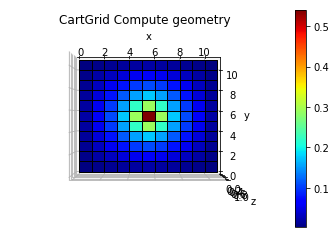

In [4]:
problem = darcyEq.Darcy(g, d)
p = problem.solve()
plot_grid(g, p)

We now try to solve the same problem, but with a fracture in the domain. We create a multidimensional grid:

In [5]:
f = np.array([[0,10],[5,5]])
gb = meshing.cart_grid([f], [10,10])
gb.assign_node_ordering()

We now make use of the DarcyData class to assign data to the fracture and matrix. We wish to set zero dirichlet boundary conditions. However, the data class assigns Neumann conditions by default, so we overload the bc function. Also, we change the parameters in the fracture.

In [6]:
class MatrixDomain(darcyEq.DarcyData):
    def __init__(self, g, d):
        darcyEq.DarcyData.__init__(self, g, d)

    def bc(self):
        dir_bound = np.ravel(np.argwhere((self.grid().has_face_tag(FaceTag.DOMAIN_BOUNDARY))))
        return bc.BoundaryCondition(self.grid(), dir_bound, ['dir']*dir_bound.size)

class FractureDomain(MatrixDomain):
    def __init(self, g, d):
        MatrixDomain.__init__(self, g, d)
        
    def permeability(self):
        kxx = 100 * np.ones(self.grid().num_cells)
        return tensor.SecondOrder(2, kxx)
    
    def source(self):
        val = np.ones(self.grid().num_cells)
        val[round(self.grid().num_cells/2)] = 1
        return val
    
    def aperture(self):
        val = 0.01 * np.ones(self.grid().num_cells)
        return val
    
def assign_darcy_data(gb):
    gb.add_node_props(['problem'])
    for g, d in gb:
        if g.dim == 2:
            d['problem'] = MatrixDomain(g, d)
        else:
            d['problem'] = FractureDomain(g, d)

We are now ready to declare the problem and solve it

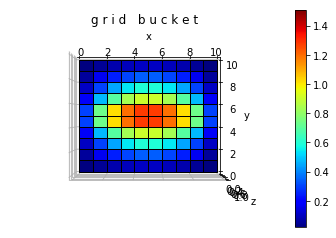

In [7]:
assign_darcy_data(gb)
problem = darcyEq.Darcy(gb)
problem.solve()
problem.split('pressure')
plot_grid(gb, 'pressure')